# Mutual Fund Data Analysis

Last Update: 17 Dec 2015

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas import Series, DataFrame, Panel, datetime
from datetime import timedelta
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import io
import os
import random
import statsmodels.stats.api as sms
from warnings import warn
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5  # Change default plot size
from ipywidgets import FloatProgress  # Progress bar
from IPython.display import display  # Progress bar

# ****************** Program Settings ******************
Data_Folder = "data/new/"
Output_Folder = "data/output/"
Datafile_Main = "fin_mf_trades_1995_2014_fid.dta"  # The main dataset - mutual fund holdings
Datafile_stocks = "compustat_finland_1990_2015_all.dta"  # The dataset - stock prices / dividends

# Calculate Daily Holdings
Dividends_Reinvested = True  # True if dividends are assumed to be fully reinvested; False otherwise.
                             # Note that the Barber's method excludes dividends
Adjust_Price_Before_1999 = True  # True if to divide 'price' before 1999 by 5.94573 
# ******************************************************

## To-Do List

1.	To get an overview of the date first:

 -	One Table for all fields of the data consisting of Numbers, Means, Medians, Stddev, Quantiles, Skewness, Kurtosis, …. Date of first observation and last,….
 -	This table separately for all single funds (over the total period)
 -	This table separately for all single years (over all funds)
 -	A list of all values for all definitions (like buy 10 and sell 20) found in the database together with the number of each of them. Do we know the meaning of all of them?
 -	The table again separately for all different definitions.
 -	A plot of aggregated daily buys and sells (and perhaps others) over the time.

2.	Daily holdings of all funds
 -	Theoretically this data will allow you to produce all holdings and stock and funds values for all funds on a daily base.
 -	If this works you could check your holdings against the holdings we got from Bloomberg or Morningstar for on specific point in time.
 -	Then you could produce similar tabs as under 1. I think if you are able to get this data, you have done a great job – and typically it takes longer than expected…..

# Variable Definitions

## DataFrame: data_main

"data_main" is the mutual fund holdings dataset. 

 - date: TR_DATE from the original dataset.
 - fund_id: identifier for funds as in Bloomberg
 - acc: identifier for funds in the Euroclear Data
 - sect: category of what types of invstors
 - buy_sell: 10 for buys; 20 for sells;
 - class: same as above (mutual funds are FI)
  - HH: Household
  - FI: Financial institution (domestic)
  - FR: Foreign with own account at euroclear
  - FI: Foreign nominee account where most foreign holdings are registered
  - NF: Non-financial
  - GG: General government
  - NP: Non-for-profit
 - leg_type: Legal type of the account holder
  - 11	NATURAL PERSON		
  - 12	ESTATE OF A DECEASED PERSON		
  - 13	TAXATION CONSORTIUM		
  - 14	PARTNERSHIP		
  - 15	BANKRUPT'S ESTATE		
  - 21	LIMITED PARTNERSHIP		
  - 22	LAIVAISÄNNISTÖYHTIÖ (EI OSAKEYHTIÖ)		
  - 30	PUBLIC LIMITED COMPANY		
  - 31	LIMITED COMPANY		
  - 32	MUTUAL INSURANCE COMPANY		
  - 33	SAVINGS BANK		
  - 34	PENSION TRUST OR FUND		
  - 35	HOUSING CORPORATION		
  - 41	COOPERATIVE		
  - 51	FOUNDATION, FUND		
  - 52	NON-PROFIT ASSOCIATION		
  - 53	MUTUAL INDEMNITY INSURANCE ASSOCIATION		
  - 54	ECONOMIC ASSOCIATION		
  - 61	PUBLIC AUTHORITY		
  - 62	PUBLIC UTILITY		
  - 63	PUBLIC CORPORATION		
  - 71	STATE CHURCH		
  - 72	OTHER RELIGIOUS COMMUNITY		
  - 90	OTHER JURIDICAL FORM
 - ref_code: Reference code of the transaction
  - 01	MARKETPLACE TRADE		
  - 02	OTHER TRADE		
  - 03	TRANSFER TO BOOK-ENTRIES		
  - 04	TRANSFER TO OWN ACCOUNT		
  - 05	CONVERSION		
  - 06	BEQUEST		
  - 07	INHERITANCE		
  - 08	WILL		
  - 09	DIVISION OF HTE PROPERTY OF THE SPOU		
  - 10	FORCED SALE		
  - 11	TRANSFER INT. CERTIFICATE OF OWN		
  - 12	TRANSFER OF INTERNAT. CERTIFICATE
  - 13	TRANSFER TO NOM.REG B-E ACCOUNT
  - 14	TRANSFER FROM NOM.REG B-E ACCOUNT
  - 15	TRADE-BY-TRADE SETTLEMENT
  - 16	DIRECT SELLING
  - 17	TRANSFER OF COLLATERAL
  - 18	RETURN OF COLLATERAL
  - 19	CANCELLATION OF RELATIONSHIP BASED O
  - 20	ISSUE ACCOUNT TRANSACTION
  - 50	RIGHTS ISSUE
  - 51	BONUS ISSUE
  - 52	SUBSCRIPTION
  - 53	FORFEITURE
  - 54	REDEMPTION
  - 55	SPLIT
  - 56	MERGER
  - 57	COMBINATION
  - 58	CANCELLATION OF A SECURITY
  - 59	OTHER SUBSCRIPTION
  - 60	SUBSCRIPTION RIGHT
  - 61	TRANSFER OF RECORD TIME
  - 62	SECURITY TYPE CONVERSION
  - 63	CANCELLING OF SECURITY TYPE LOAN
  - 64	REVERSE SPLIT
  - 65	CANCELLATION OF SUBSCRIPTION
  - 71	CONVERSION OF CONVERTIBLE BOND
  - 72	SUBSCRIPTION WITH WARRANT
  - 73	EXECUTION OF WARRANT
  - 75	DEMERGER
  - 76	STOCK LOAN
  - 77	RETURN OF STOCK LOAN
  - 78	RERUTN OF WARRANTS
  - 96	ACCOUNT TRANSFER
  - 97	ARCHIVING
  - 98	CORRECTION
  - 99	OTHER
 - volume: transaction volume
 - price: transaction price
 - prccd: market closing price (sourced from COMPUSTAT)
 - ajexdi: adjustment factor for stock prices (sourced from COMPUSTAT)
 - cshoc: Number of shares on issue (sourced from COMPUSTAT)
 - trans_date: Date of settlement
 - trade_date: Date of trade

  

# Import Data

In [3]:
data_main = pd.read_stata(Data_Folder + Datafile_Main)
data_main.columns = [var.lower() for var in data_main.columns]

# There are several datetime variables -> remove the unused ones
data_main = data_main.drop(['date', 'tr_date', 'trans_date'], axis=1)

# Convert trade_date to datetime
data_main['date'] = pd.to_datetime(data_main.trade_date)

date_main = data_main.sort_index(axis=1)

date_main = data_main.sort_values(by=['fund_id', 'date', 'isin', 'buy_sell'])

data_main.head(10)



,fund_id,isin,acc,sect,owntype,legtype,ref_code,buy_sell,volume,price,...,pcode,country,language,prccd,ajexdi,cshoc,trade_date,class,nom_ind,date
0,FI0008803119,FI0009000251,1128458,260,1,31,1,10,1000,228,...,75,,1,227.00,3.4137,6124980,1994-12-27,FI,0,1994-12-27
1,FI0008803119,FI0009000582,1128458,260,1,31,1,10,15000,131,...,75,,1,129.00,1.0000,82000000,1994-12-29,FI,0,1994-12-29
2,FI0008803119,FI0009000707,1128458,260,1,31,1,20,600,702,...,75,,1,700.00,8.0000,37596439,1994-12-29,FI,0,1994-12-29
3,FI0008803119,FI0009000707,1128458,260,1,31,1,20,200,702,...,75,,1,700.00,8.0000,37596439,1994-12-29,FI,0,1994-12-29
4,FI0008803119,FI0009000012,1128458,260,1,31,0,10,196000,0,...,75,,1,5.53,1.0000,726845084,1995-01-01,FI,0,1995-01-01
5,FI0008803119,FI0009000053,1128458,260,1,31,0,10,294000,0,...,75,,1,12.20,1.0000,416794279,1995-01-01,FI,0,1995-01-01
6,FI0008803119,FI0009000061,1128458,260,1,31,0,10,150000,0,...,75,,1,11.80,1.0000,67200000,1995-01-01,FI,0,1995-01-01
7,FI0008803119,FI0009000145,1128458,260,1,31,0,10,67000,0,...,75,,1,51.60,3.0000,20070000,1995-01-01,FI,0,1995-01-01
8,FI0008803119,FI0009000202,1128458,260,1,31,0,10,90000,0,...,75,,1,55.00,1.0000,90213400,1995-01-01,FI,0,1995-01-01
9,FI0008803119,FI0009000251,1128458,260,1,31,0,10,12500,0,...,75,,1,226.00,3.4137,6124980,1995-01-01,FI,0,1995-01-01


## Generate Variables

In [4]:
# Generate some variables
data_main['buy'] = (data_main.buy_sell == 10) | (data_main.buy_sell == 11)
data_main['sell'] = (data_main.buy_sell == 20) | (data_main.buy_sell == 21)
data_main['buy_volume'] = data_main['buy']*data_main['volume']
data_main['sell_volume'] = data_main['sell']*data_main['volume']
data_main['buy_value'] = data_main['buy_volume']*data_main['price']
data_main['sell_value'] = data_main['sell_volume']*data_main['price']

# Descriptive Statistics 

## Numerical Variables

In [5]:
def sum_stats(col):
    """Produce a table of summary statistics for a numerical variable"""
    count = col.count()
    mean = col.mean()
    median = col.median()
    stddev = col.std()
    skewness = col.skew()
    kurtosis = col.kurt()
    quantile1 = col.quantile(0.25)
    quantile2 = col.quantile(0.5)
    quantile3 = col.quantile(0.75)
    first_obs_index = col.first_valid_index()
    last_obs_index = col.last_valid_index()
    
    return pd.Series([count, mean, median, stddev, skewness, kurtosis, quantile1, quantile2, quantile3, first_obs_index, last_obs_index],
                         index=['count', 'mean', 'median', 'stddev', 'skewness', 'kurtosis', 'quantile1', 'quantile2', 'quantile3', 'first_obs_index', 'last_obs_index']
                        )
    
print("Descriptive Statistics for Numerical Variables:")

stats = data_main[['volume', 'price', 'prccd', 'ajexdi', 'cshoc', 'date']].sort_values(by=['date']).drop('date', axis=1).apply(sum_stats).T

# Fix up the dates
stats['first_obs'] = data_main.date[stats.T.ix['first_obs_index']].values 
stats['last_obs'] = data_main.date[stats.T.ix['last_obs_index']].values 
stats

Descriptive Statistics for Numerical Variables:


,count,mean,median,stddev,skewness,kurtosis,quantile1,quantile2,quantile3,first_obs_index,last_obs_index,first_obs,last_obs
volume,290141,1.724857e+04,2.000000e+03,8.851346e+04,46.630421,4273.024135,500.00,2.000000e+03,1.000000e+04,127041,185236,1994-12-19,2014-12-26
price,290141,4.633595e+01,1.713000e+01,8.849064e+01,4.661467,30.979461,10.18,1.713000e+01,3.530000e+01,127041,185236,1994-12-19,2014-12-26
prccd,287501,4.708490e+01,1.737000e+01,8.993040e+01,4.693060,31.570475,10.40,1.737000e+01,3.600000e+01,127041,185236,1994-12-19,2014-12-26
ajexdi,287501,2.164172e+00,1.000000e+00,3.867670e+00,7.520359,87.975780,1.00,1.000000e+00,1.237900e+00,127041,185236,1994-12-19,2014-12-26
cshoc,287465,4.049428e+08,1.277820e+08,8.712507e+08,3.873649,14.645906,60844580.00,1.277820e+08,2.688760e+08,127041,185236,1994-12-19,2014-12-26


## Categorical Variables


In [6]:
def_class = {
    'HH': 'Household',
    'FI': 'Financial institution (domestic)',
    'FR': 'Foreign with own account at euroclear',
    'FI': 'Foreign nominee account where most foreign holdings are registered',
    'NF': 'Non-financial',
    'GG': 'General government',
    'NP': 'Non-for-profit',
    'NA': "Not Available"
} 

def_legtype = {
    11 : 'NATURAL PERSON',
    12 : 'ESTATE OF A DECEASED PERSON',
    13 : 'TAXATION CONSORTIUM',
    14 : 'PARTNERSHIP',
    15 : "BANKRUPT'S ESTATE",
    21 : 'LIMITED PARTNERSHIP',
    22 : 'LAIVAISÄNNISTÖYHTIÖ (EI OSAKEYHTIÖ)',
    30 : 'PUBLIC LIMITED COMPANY',
    31 : 'LIMITED COMPANY',
    32 : 'MUTUAL INSURANCE COMPANY',
    33 : 'SAVINGS BANK',
    34 : 'PENSION TRUST OR FUND',
    35 : 'HOUSING CORPORATION',
    41 : 'COOPERATIVE',
    51 : 'FOUNDATION, FUND',
    52 : 'NONPROFIT ASSOCIATION',
    53 : 'MUTUAL INDEMNITY INSURANCE ASSOCIATION',
    54 : 'ECONOMIC ASSOCIATION',
    61 : 'PUBLIC AUTHORITY',
    62 : 'PUBLIC UTILITY',
    63 : 'PUBLIC CORPORATION',
    71 : 'STATE CHURCH',
    72 : 'OTHER RELIGIOUS COMMUNITY',
    90 : 'OTHER JURIDICAL FORM',
    'NA': "Not Available"
}

def_ref_code = {
    1 : 'MARKETPLACE TRADE',
    2 : 'OTHER TRADE',
    3 : 'TRANSFER TO BOOKENTRIES',
    4 : 'TRANSFER TO OWN ACCOUNT',
    5 : 'CONVERSION',
    6 : 'BEQUEST',
    7 : 'INHERITANCE',
    8 : 'WILL',
    9 : 'DIVISION OF HTE PROPERTY OF THE SPOU',
    10 : 'FORCED SALE',
    11 : 'TRANSFER INT. CERTIFICATE OF OWN',
    12 : 'TRANSFER OF INTERNAT. CERTIFICATE',
    13 : 'TRANSFER TO NOM.REG BE ACCOUNT',
    14 : 'TRANSFER FROM NOM.REG BE ACCOUNT',
    15 : 'TRADEBYTRADE SETTLEMENT',
    16 : 'DIRECT SELLING',
    17 : 'TRANSFER OF COLLATERAL',
    18 : 'RETURN OF COLLATERAL',
    19 : 'CANCELLATION OF RELATIONSHIP BASED O',
    20 : 'ISSUE ACCOUNT TRANSACTION',
    50 : 'RIGHTS ISSUE',
    51 : 'BONUS ISSUE',
    52 : 'SUBSCRIPTION',
    53 : 'FORFEITURE',
    54 : 'REDEMPTION',
    55 : 'SPLIT',
    56 : 'MERGER',
    57 : 'COMBINATION',
    58 : 'CANCELLATION OF A SECURITY',
    59 : 'OTHER SUBSCRIPTION',
    60 : 'SUBSCRIPTION RIGHT',
    61 : 'TRANSFER OF RECORD TIME',
    62 : 'SECURITY TYPE CONVERSION',
    63 : 'CANCELLING OF SECURITY TYPE LOAN',
    64 : 'REVERSE SPLIT',
    65 : 'CANCELLATION OF SUBSCRIPTION',
    71 : 'CONVERSION OF CONVERTIBLE BOND',
    72 : 'SUBSCRIPTION WITH WARRANT',
    73 : 'EXECUTION OF WARRANT',
    75 : 'DEMERGER',
    76 : 'STOCK LOAN',
    77 : 'RETURN OF STOCK LOAN',
    78 : 'RERUTN OF WARRANTS',
    96 : 'ACCOUNT TRANSFER',
    97 : 'ARCHIVING',
    98 : 'CORRECTION',
    99 : 'OTHER',
    0  : 'Not Available',
    'NA': "Not Available"
}


In [7]:
def tab(col, desc=None):
    """Create a simple tabluation table for a categorical variable."""
    obs = len(col)
    
    # convert .value_counts() to a DataFrame
    df = pd.DataFrame(col.value_counts()).reset_index()
    df.columns = ['code', 'obs']
    
    if desc is not None:
        df['desc'] = df.code.apply(lambda x: desc[x])
    else:
        df['desc'] = np.nan
        
    df.sort_index(axis=1, inplace=True)
    total_freq = np.sum(df.obs)
    df['percent'] = df['obs'] / total_freq * 100
    
    # report missing observations
    df.loc[len(df)] = [np.nan, 'non-missing obs; <-- divided by total obs;', col.count(), col.count()/obs*100]
    
    return df

### class


In [8]:
var = 'class'
dct = def_class
print("Summary statistics of variable: {}".format(var))
tab(data_main[var], dct)

Summary statistics of variable: class


,code,desc,obs,percent
0,FI,Foreign nominee account where most foreign hol...,270883,93.362538
1,NF,Non-financial,13026,4.489541
2,NA,Not Available,6232,2.147921
3,NaN,non-missing obs; <-- divided by total obs;,290141,100.000000


### legtype

In [9]:
var = 'legtype'
dct = def_legtype
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: legtype


,code,desc,obs,percent
0,51,"FOUNDATION, FUND",155321,53.532937
1,90,OTHER JURIDICAL FORM,100277,34.561472
2,31,LIMITED COMPANY,18410,6.345191
3,30,PUBLIC LIMITED COMPANY,8609,2.967178
4,54,ECONOMIC ASSOCIATION,7524,2.593222
5,NaN,non-missing obs; <-- divided by total obs;,290141,100.000000


### ref_code

In [10]:
var = 'ref_code'
dct = def_ref_code
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: ref_code


,code,desc,obs,percent
0,1,MARKETPLACE TRADE,225797,77.823196
1,2,OTHER TRADE,57017,19.651480
2,4,TRANSFER TO OWN ACCOUNT,2732,0.941611
3,76,STOCK LOAN,1004,0.346039
4,77,RETURN OF STOCK LOAN,977,0.336733
5,96,ACCOUNT TRANSFER,454,0.156476
6,99,OTHER,416,0.143379
7,55,SPLIT,390,0.134417
8,98,CORRECTION,287,0.098917
9,57,COMBINATION,247,0.085131


### buy_sell

In [11]:
def_buy_sell = {10: "buy", 20: "sell",
                11: "what is this?", 
                21: "Not sure what is this?"}

var = 'buy_sell'
dct = def_buy_sell
print("Summary statistics of variable: {}".format(var))

warn("Code 11, Code 21's definitions are unclear.")

tab(data_main[var], dct)


Summary statistics of variable: buy_sell


/usr/local/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:9: UserWarning: Code 11, Code 21's definitions are unclear.


,code,desc,obs,percent
0,10,buy,150573,51.896492
1,20,sell,139557,48.099717
2,11,what is this?,7,0.002413
3,21,Not sure what is this?,4,0.001379
4,NaN,non-missing obs; <-- divided by total obs;,290141,100.000000


### owntype

In [12]:
var = 'owntype'
dct = None
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: owntype


,code,desc,obs,percent
0,1,NaN,290141,100
1,NaN,non-missing obs; <-- divided by total obs;,290141,100


### sect

In [13]:
var = 'sect'
dct = None
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: sect


,code,desc,obs,percent
0,123000,NaN,135802,46.805519
1,260,NaN,127215,43.845923
2,111211,NaN,8063,2.778994
3,122200,NaN,7866,2.711096
4,124100,NaN,5149,1.774654
5,121,NaN,4963,1.710548
6,111020,NaN,1083,0.373267
7,NaN,non-missing obs; <-- divided by total obs;,290141,100.000000


### currency

In [14]:
var = 'currency'
dct = None
print("Summary statistics of variable: {}".format(var))

print('20% of transactions are based in currency FIM.')

tab(data_main[var], dct)


Summary statistics of variable: currency
20% of transactions are based in currency FIM.


,code,desc,obs,percent
0,EUR,NaN,231290,79.716414
1,FIM,NaN,58851,20.283586
2,NaN,non-missing obs; <-- divided by total obs;,290141,100.000000


### byear

In [15]:
var = 'byear'
dct = None
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: byear


,code,desc,obs,percent
0,NaN,non-missing obs; <-- divided by total obs;,0,0


### gender

In [16]:
var = 'gender'
dct = None
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: gender


,code,desc,obs,percent
0,1,NaN,102049,77.205738
1,2,NaN,30129,22.794262
2,NaN,non-missing obs; <-- divided by total obs;,132178,45.556471


### pcode

In [17]:
var = 'pcode'
dct = None
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: pcode


,code,desc,obs,percent
0,101,NaN,67780,23.361055
1,100,NaN,60932,21.000824
2,510,NaN,56073,19.326121
3,20,NaN,46471,16.016695
4,131,NaN,25457,8.774010
5,75,NaN,21277,7.333331
6,2650,NaN,6036,2.080368
7,180,NaN,3110,1.071893
8,120,NaN,3005,1.035703
9,NaN,non-missing obs; <-- divided by total obs;,290141,100.000000


### country

In [18]:
var = 'country'
dct = None
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: country


,code,desc,obs,percent
0,,NaN,247761,85.393309
1,FI,NaN,42380,14.606691
2,NaN,non-missing obs; <-- divided by total obs;,290141,100.000000


### language

In [19]:
var = 'language'
dct = None
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: language


,code,desc,obs,percent
0,1,NaN,237363,81.809534
1,2,NaN,52778,18.190466
2,NaN,non-missing obs; <-- divided by total obs;,290141,100.000000


### nom_ind

In [20]:
var = 'nom_ind'
dct = None
print("Summary statistics of variable: {}".format(var))

tab(data_main[var], dct)

Summary statistics of variable: nom_ind


,code,desc,obs,percent
0,0,NaN,290141,100
1,NaN,non-missing obs; <-- divided by total obs;,290141,100


## Descriptive Stats by Funds

In [21]:
grouped = data_main.groupby('fund_id', as_index=False, axis=0)

list_of_numerical_vars = ['volume', 'price', 'prccd', 'ajexdi', 'cshoc', 'date']
list_of_categorical_vars = ['class', 'legtype', 'ref_code', 'buy_sell', 'sect', 'gender', 'pcode']
dict_of_categorical_vars = {'class': def_class, 
                            'legtype': def_legtype, 
                            'ref_code': def_ref_code, 
                            'buy_sell': def_buy_sell, 
                            'sect': None, 
                            'gender': None, 
                            'pcode': None}

In [22]:
for name, group in grouped:
    print("**********  Fund: {}  **********".format(name))
    print("Numerical variables:")
    print(group[list_of_numerical_vars].describe().T)
    print("\n")
    
    print("Categorical variables:")
    for var in list_of_categorical_vars:
        print("- Variable: {}".format(var))
        print(tab(group[var], dict_of_categorical_vars[var]).to_string(index=False))
        print("\n")
    print("\n")
    print("\n")

**********  Fund: FI0008800016  **********
Numerical variables:
        count          mean           std          min            25%  \
volume  18926  2.247476e+04  1.204354e+05       1.0000       543.0000   
price   18926  4.297073e+01  7.806916e+01       0.0000        10.5100   
prccd   18682  4.400443e+01  8.020642e+01       0.1200        10.8525   
ajexdi  18682  1.920676e+00  3.416968e+00       0.1144         1.0000   
cshoc   18680  4.214782e+08  8.997133e+08  477836.0000  53150000.0000   

                 50%           75%         max  
volume  2.700000e+03  1.400000e+04     7662900  
price   1.937500e+01  3.300000e+01         990  
prccd   1.998000e+01  3.310000e+01         990  
ajexdi  1.000000e+00  1.231800e+00          64  
cshoc   1.246307e+08  2.670158e+08  4796292460  


Categorical variables:
- Variable: class
code                                               desc    obs     percent
  FI  Foreign nominee account where most foreign hol...  17471   92.312163
  NA      

## Descriptive Stats by Year

In [23]:
# Resampling from daily to annually
# How to down-sample from daily to annually? Some variables are computed as means; some are aggregated.
vars_compute_average = ['price', 'prccd', 'ajexdi', 'cshoc']
vars_compute_sum = ['buy_value', 'sell_value', 'buy_volume', 'sell_volume', 'buy', 'sell']

In [24]:
ts_main = data_main
ts_main.index = ts_main.date

In [25]:
ts_temp_mean = ts_main[vars_compute_average].resample('A', how='mean')
ts_temp_sum = ts_main[vars_compute_sum].resample('A', how='sum')
ts_annual = pd.concat([ts_temp_mean, ts_temp_sum], axis=1)
ts_annual.columns = ['avg_price', 'avg_prccd', 'avg_ajexdi', 'avg_cshoc', 'sum_buy_value', 'sum_sell_value', 'sum_buy_vol', 'sum_sell_vol', 'sum_buys', 'sum_sells']
print('Variable definitions:')
print('sum_buys: number of buys during the year')
print('sum_buy_vol: total buy volume during the year')
print('sum_buy_value (in 000,000s): total turonver of purchase value during the year')
ts_annual['sum_buy_value'] = ts_annual['sum_buy_value']/1000000 
ts_annual['sum_sell_value'] = ts_annual['sum_sell_value']/1000000 
ts_annual

Variable definitions:
sum_buys: number of buys during the year
sum_buy_vol: total buy volume during the year
sum_buy_value (in 000,000s): total turonver of purchase value during the year


,avg_price,avg_prccd,avg_ajexdi,avg_cshoc,sum_buy_value,sum_sell_value,sum_buy_vol,sum_sell_vol,sum_buys,sum_sells
date,,,,,,,,,,
1994-12-31,153.809259,150.693889,6.528385,1.104380e+08,35.499000,26.813600,567400,589800,78,84
1995-12-31,138.213604,141.753156,6.147319,1.234849e+08,3683.562927,3833.692808,69590197,59328435,6512,7352
1996-12-31,116.350465,116.608281,5.765767,1.188861e+08,3784.796712,4072.432073,57469672,58546592,7438,8747
1997-12-31,161.441175,161.995295,4.636617,1.342176e+08,4616.198175,4483.420826,59152263,55704503,6818,6925
1998-12-31,208.063459,210.618799,4.112164,1.912685e+08,5439.818231,5210.158386,52115245,48363473,7748,7265
1999-12-31,34.303839,34.479339,2.675440,3.979546e+08,897.252070,899.840589,49069080,46026064,7576,7739
2000-12-31,33.533031,33.803717,1.948758,5.694018e+08,1437.123104,1316.744530,73429956,62885140,6949,6682
2001-12-31,13.694342,13.775393,1.569920,5.771282e+08,734.365436,654.063640,80264119,59810924,5268,4839
2002-12-31,13.404859,13.470798,1.533537,8.072455e+08,629.125871,590.531031,63529511,65233958,5174,4418


## Stats by Fund and by Year

Iterating statistics by fund and year produces a lot of outputs, the analysis is thus restricted to a few variables.

## Plots

### Time Series Plots - Number of Buys / Sells per Fund

In [26]:
ts_buys = data_main[['fund_id', 'buy', 'sell', 'buy_value', 'sell_value', 'date']].copy()
ts_buys.index = ts_buys.date
ts_buys.drop('date', axis=1, inplace=True)


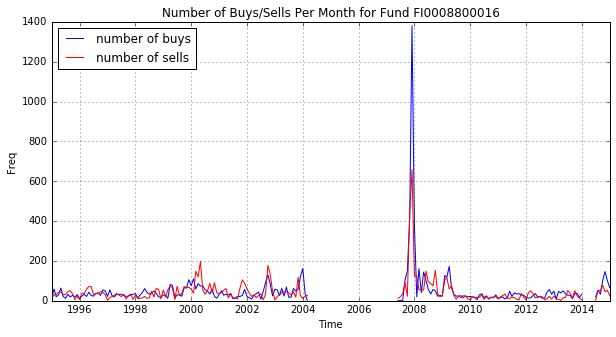

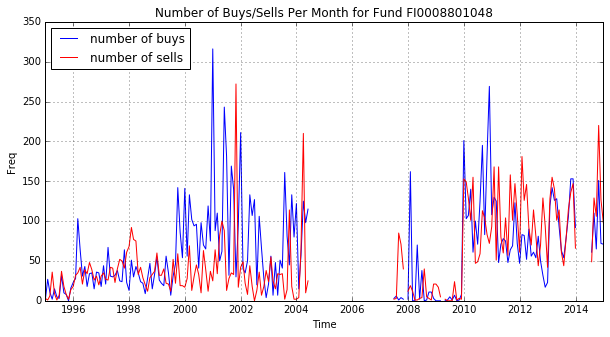

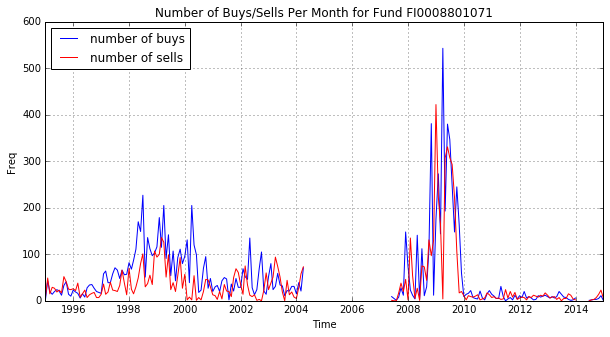

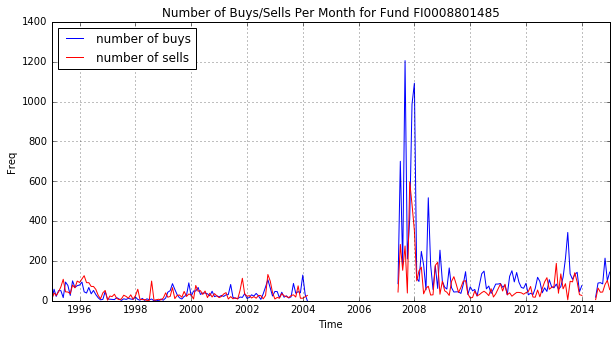

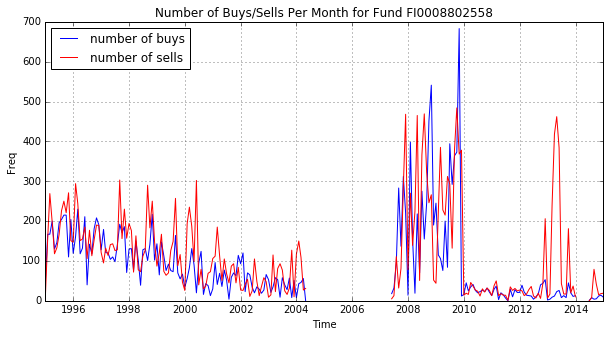

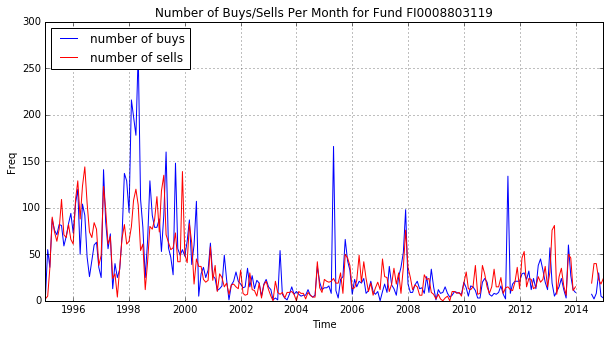

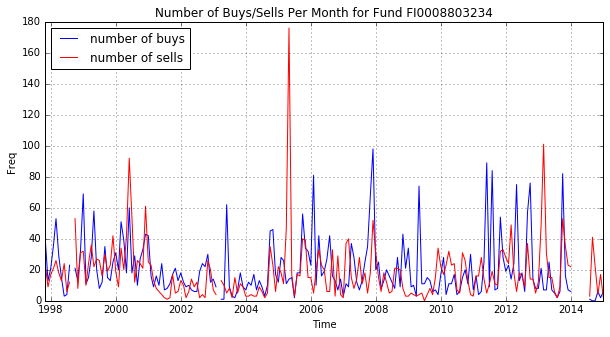

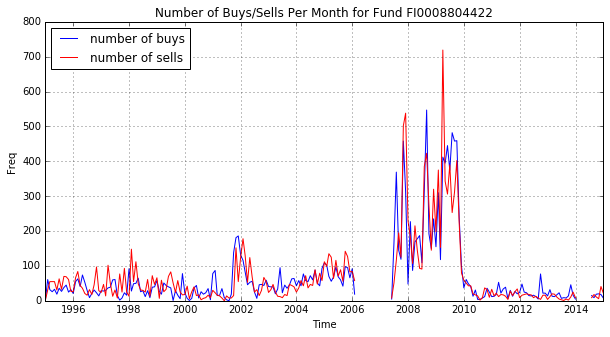

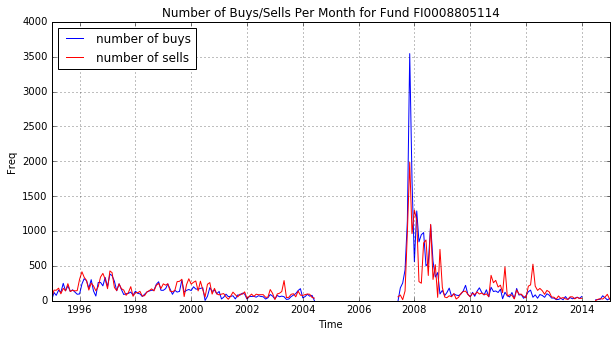

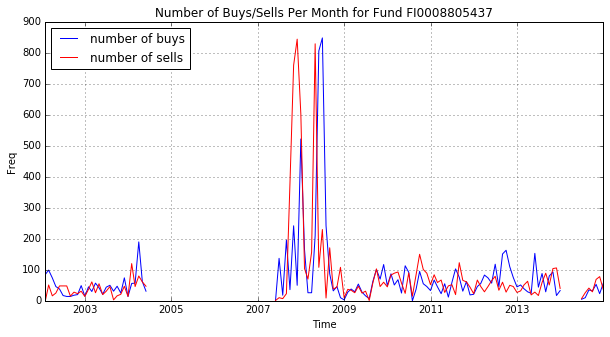

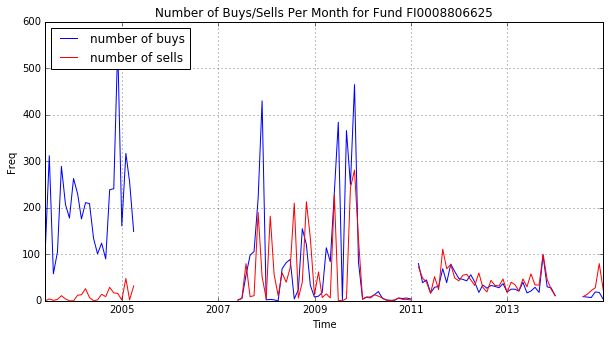

In [27]:
# Group by fund_id
ts_buys_grouped = ts_buys.groupby('fund_id', as_index=False, axis=0)
i = 1
for name, group in ts_buys_grouped:
    # Resample from daily
    ts_temp = group.drop('fund_id', axis=1).resample('M', how='sum')
    
    # Plot
    plt.figure(i)
    plt.plot(ts_temp.index, ts_temp.buy, 'b', label='number of buys')
    plt.plot(ts_temp.index, ts_temp.sell, 'r', label='number of sells')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Freq')
    plt.grid(True)
    plt.title('Number of Buys/Sells Per Month for Fund {}'.format(name))
    i += 1
    
plt.show()

### Time Series Plots - Turnover of Buys/Sells per Fund

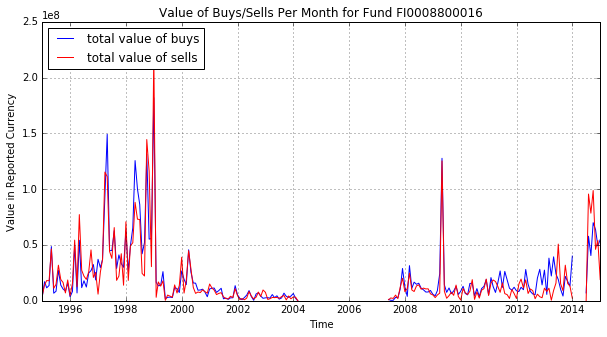

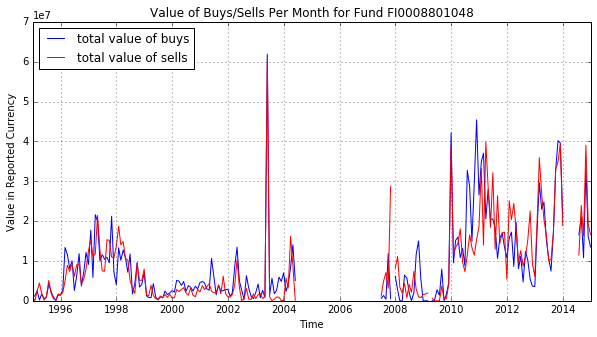

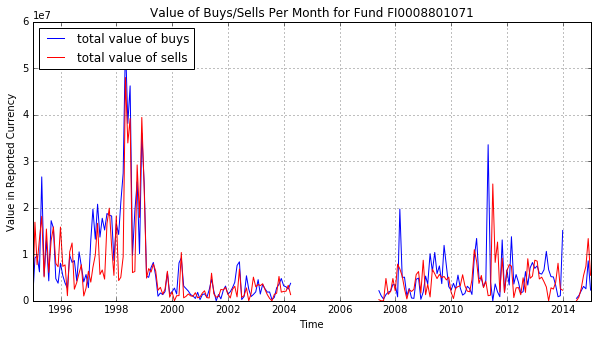

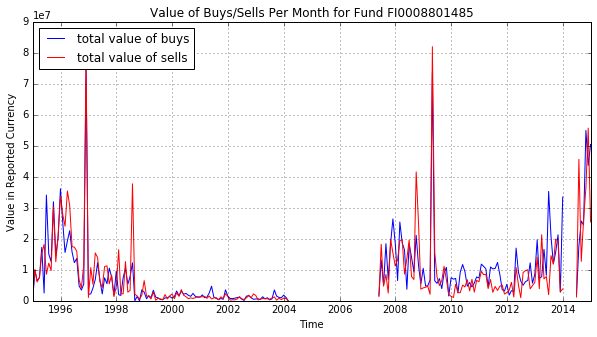

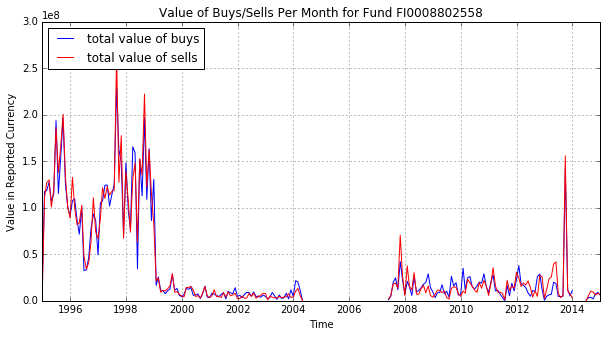

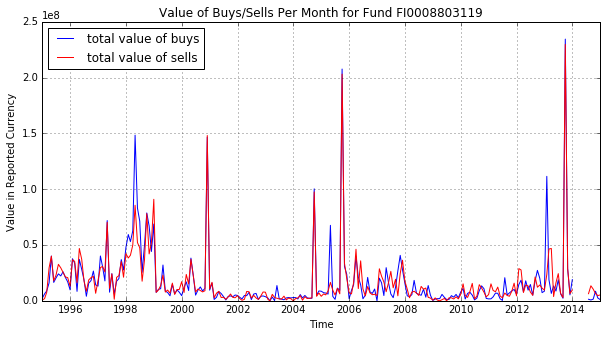

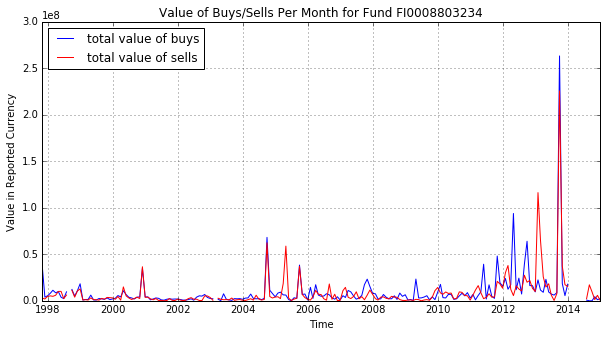

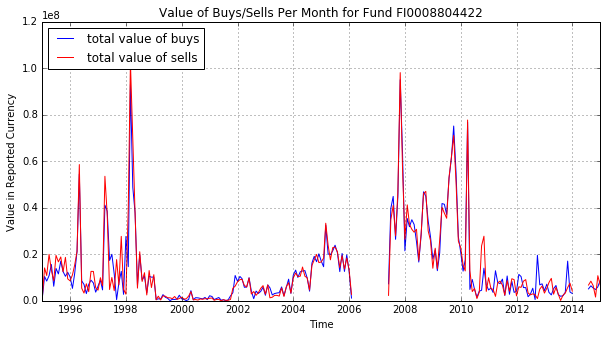

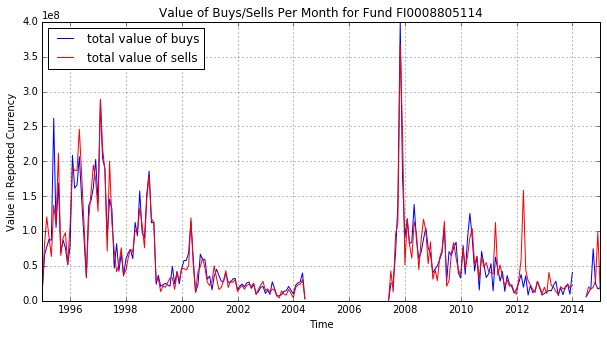

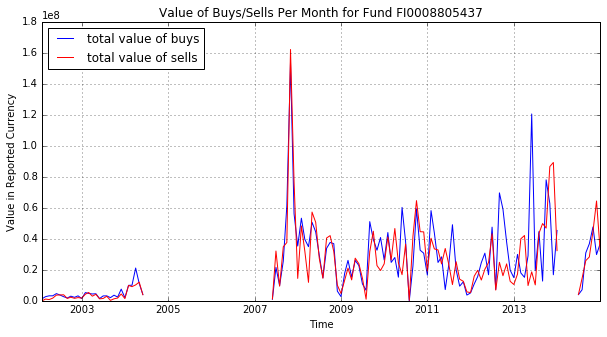

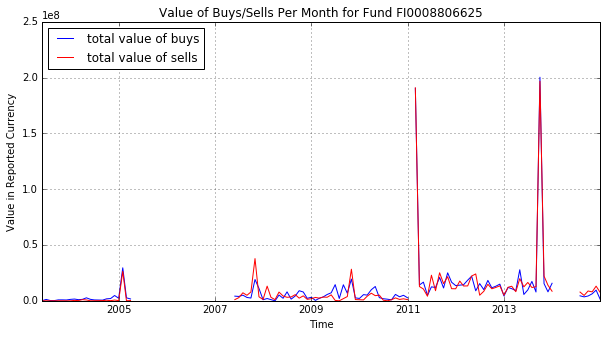

In [28]:
# Group by fund_id
i = 1
for name, group in ts_buys_grouped:
    # Resample from daily
    ts_temp = group.drop('fund_id', axis=1).resample('M', how='sum')
    
    # Plot
    plt.figure(i)
    plt.plot(ts_temp.index, ts_temp.buy_value, 'b', label='total value of buys')
    plt.plot(ts_temp.index, ts_temp.sell_value, 'r', label='total value of sells')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Value in Reported Currency')
    plt.grid(True)
    plt.title('Value of Buys/Sells Per Month for Fund {}'.format(name))
    i += 1
    
plt.show()

# Calculating Daily Holdings using FIFO 

This method makes use of First-In-First-Out principle to calculate stock returns. Cash dividends can be assumed to be fully reinvested (see the switches at the beginning of the program).

In [37]:
# ajexdi contains the ratio to derive holding volume after stock splits
data_stocks = pd.read_stata(Data_Folder + Datafile_stocks)

# Format date
data_stocks['date'] = pd.to_datetime(data_stocks['date'], format="%Y%m%d")

# Keep only useful variables
data_stocks = data_stocks[['isin', 'date', 'ajexdi', 'div', 'prccd']]

data_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741690 entries, 0 to 741689
Data columns (total 5 columns):
isin      741690 non-null object
date      741690 non-null datetime64[ns]
ajexdi    741288 non-null float64
div       2875 non-null float64
prccd     741288 non-null float64
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 34.0+ MB


Dealing with missing data in the stock price data.

In [38]:
# Identify the number of missing isin
print("Number of missing isin entries in the stocks price data: {}".format(len(data_stocks[data_stocks['isin']==""])))
print("These missing entries are dropped.")
data_stocks.drop(data_stocks.index[data_stocks['isin']==""], inplace=True)

print("\n")
# Checking zero dividend payments
print("Number of zero-dividends paymetns: {}".format(np.sum(data_stocks['div']==0)))
print("zero-dividend payments are replaced as missing.")
data_stocks.ix[data_stocks['div']==0, 'div'] = np.nan

print("\n")
# Check missing prccd
print("Number of missing prccd entries: {}".format(np.sum(np.isnan(data_stocks['prccd']))))
print("They are dropped")
data_stocks.drop(data_stocks.index[np.isnan(data_stocks['prccd'])], inplace=True)

print("\n")
# Check missing ajexdi
print("Number of missing ajexdi entries: {}".format(np.sum(np.isnan(data_stocks['ajexdi']))))
print("They are dropped")
data_stocks.drop(data_stocks.index[np.isnan(data_stocks['ajexdi'])], inplace=True)

Number of missing isin entries in the stocks price data: 46583
These missing entries are dropped.


Number of zero-dividends paymetns: 0
zero-dividend payments are replaced as missing.


Number of missing prccd entries: 356
They are dropped


Number of missing ajexdi entries: 0
They are dropped


## Compute the dividend index (divIndex)

In [ ]:
# display the floating progress bar
f = FloatProgress(min=0, max=1)
display(f)

data_stocks['divIndex'] = 0
data_stocks.sort_values(by=['isin', 'date'], inplace=True)
gp_temp = data_stocks.groupby(by='isin', as_index=False)

# Identify the first entry per isin
df_temp = gp_temp.first()[['isin', 'date']]  
df_temp['first'] = 1

# Merge back
data_stocks = data_stocks.merge(df_temp, how="outer", on=['isin', 'date'])
data_stocks.ix[data_stocks['first']==1, 'divIndex'] = 1
data_stocks.drop('first', axis=1, inplace=True)

# Compute the rest of the divIndex
total_obs = len(data_stocks)
gp_temp = data_stocks.groupby(by='isin', as_index=False)
for name, group in gp_temp:
    # Reset all variables when moving to a new stock
    cumIndex = 1
    previousPrice = group.ix[group.index[0], 'prccd']  # get the first row
    
    for index, row in group.iterrows():
        # print("now in stock {} row {}".format(name, index))
        # print("cumIndex is {}".format(cumIndex))
        # check if there is a dividend payment
        if (not np.isnan(row['div'])) & (row['div']!=0):
            cumIndex = cumIndex*( row['div'] / previousPrice + 1)
            previousPrice = row['prccd']
        else:
            # There is no dividend payment
            previousPrice = row['prccd']
            
        data_stocks.ix[index, 'divIndex'] = cumIndex
        f.value = index/total_obs

data_stocks.head()

## Adjust adjexdi to include dividend payments

The original ajexdi is assumed to exclude dividends. The ajexdi is adjusted so that it accounts for the implications of dividends.

In [ ]:
def add_modAjexdi(grp):
    """Calculate mod_ajexdi per group."""
    grp['modAjexdi'] = np.nan
    
    for index, row in grp.iterrows():
        if index==grp.index[0]:
            grp.ix[index, 'modAjexdi'] = grp.ix[index, 'ajexdi']
        else:
            grp.ix[index, 'modAjexdi'] = grp.ix[index - 1, 'modAjexdi'] \
                                         / grp.ix[index -1, 'ajexdi'] \
                                         * grp.ix[index, 'ajexdi'] \
                                         / grp.ix[index, 'firstDiffDivIndex']
    return grp

if  Dividends_Reinvested:
    # Adjust ajexdi to account for dividends
    first_diff = lambda x: x / x.shift(1)
    data_stocks['firstDiffDivIndex'] = data_stocks.groupby(by='isin', as_index=False)['divIndex'].transform(first_diff)
    data_stocks = data_stocks.groupby(by='isin', as_index=False).apply(add_modAjexdi)
 
data_stocks.sort_values(by=['isin', 'date'], inplace=True)
data_stocks = data_stocks[['isin', 'date', 'divIndex', 'ajexdi']]
data_stocks.info()

Find the initial values of ajexdi per stock.

In [ ]:
data_initial_index = data_stocks.groupby(by=['isin'], as_index=False).first()
data_initial_index.columns = ['isin', 'initialDate', 'initialDivIndex', 'initialAjexdi']
data_initial_index.head()

## Calculate the initial holdings for each fund

Adjust stock purchase/sell prices before 1999

In [ ]:
if Adjust_Price_Before_1999:
    data_main.ix[:"1999-Jan-01", 'price'] = data_main.ix[:"1999-Jan-01", 'price']/5.94573  

In [ ]:
# Merge data
data_main.merge(data_stocks, how='inner', on=['isin', 'date'])

In [ ]:
# Create Adjusted Volume
data_main['adjSellVolume'] = 0
data_main.ix[data_main['buy_sell']==20, 'adjSellVolume'] = data_main['volume']

data_main['adjBuyVolume'] = 0
data_main.ix[data_main['buy_sell']==10, 'adjBuyVolume'] = data_main['volume']

data_main['cumulativeVolume'] = 0

In [ ]:
# check if there is any missing values in ajexdi and divIndex
# if there is, replace the initial ajexdi as the largest value
# and replace the initial divIndex as the smallest value

## Check for Over-Sales

Some funds may "over-sale" their stocks and result in negative balance. This section prohibits negative balances by identifying all possible "over-sales" and lower the sell-volume to the level that the holdings of zero shares occur at the point of sale. Subsequent sales are then void.

In [ ]:
# Progress bar
f = FloatProgress(min=0, max=1)
display(f)
total_obs = len(data_stocks)

# Check for over-sales
data_main.sort_values(by=['fund_id', 'isin', 'date'], inplace=True)

gp_temp = data_main.groupby(by=['fund_id', 'isin'], as_index=False)
for name, group in gp_temp:
    # Reset variables when moving to a new stock
    first_row = group.index[0]
    # If the first entry is a sell before buy --> the beginning balance is negative.
    cumVolume = 0
    previousAjexdi = group.ix[first_row, 'ajexdi'] 
    
    for index, row in group.iterrows():
        # check if there is a buy
        if (row['buy_sell']==10) & (row['adjBuyVolume']!=0):
            cumVolume = cumVolume / row['ajexdi'] * previousAjexdi + row['adjBuyVolume'] 
            previousAjexdi = row['ajexdi']
        
        # check if there is a sell
        if (row['buy_sell']==20) & (row['adjSellVolume']!=0):
            cumVolume = cumVolume / row['ajexdi'] * previousAjexdi
            previousAjexdi = row['ajexdi']
            
            # check if sell volume exceeds cumulative volume
            if (row['adjSellVolume'] > cumVolume):
                data_main.ix[index, 'adjSellVolume'] = cumVolume
                cumVolume = 0
            else:
                cumVolume = cumVolume - row['adjSellVolume']
                
        f.value = index/total_obs        
        data_main.ix[index, 'cumulativeVolume'] = cumVolume
        

## Calcualte profits from sales

In [ ]:
data_main['profit'] = np.nan

data_main['daysSincePurchase'] = np.nan
data_main['profit'] = np.nan

# Note that profit is from sale only (not buy)
# Calcualte profit from each sale
data_main.sort_values(by=['fund_id', 'isin', 'date'])
gp_temp = data_main.groupby(by=['fund_id', 'isin'], as_index=False)

for name, group in gp_temp:
    # Move to a new stock and reset variables
    buyPrice = []
    buyVolume = []
    buyDate = []
    buyAjexdi = []
    
    salePrice = 0
    saleVol = 0
    saleRevenue = 0
    profit = 0
    daysSinceBuy = -1
    saleDate = -1
    ithPurchase = 1
    
    for index, row in group:
        # read in buyPrice and buyVolume
        if (row['buy_sell']==10) & (row['adjBuyVolume']>0):
            buyPrice.append(row['price'])
            buyVolume.append(row['adjBuyVolume'])
            buyAjexdi.append(row['ajexdi'])
            buyDate.append(index)
            ithPurchase += 1
            
        # update sellPrice and sellVolume
        if (row['buy_sell']==20) & (row['adjSellVolume']>0):
            salePrice = row['price']
            saleVol = row['adjSellVolume']
            saleRevenue = salePrice * saleVol
            saleDate = index
            saleAjexdi = row['ajexdi']
            
        # determine purchase price -- total purchase cost is purchaseCost
        qtyTaken = 0  # number of shares to take from the element in list
        purchaseCost = 0
        while saleVol > 1:
            # loop from the first element of buyVolume
            for i, vol in enumerate(buyVolume):
                if vol > 0:
                    # the ith buy's volume >0 
                    daysSinceBuy = saleDate - buyDate[i]
                    data_main.ix[index, 'daysSincePurchase'] = daysSinceBuy
                    convertedBuyVolume = vol * buyAjexdi[i] / saleAjexdi
                    
                    if saleVol > convertedBuyVolume:
                        saleVol = saleVol - convertedBuyVolume
                        purchaseCost += vol * buyPrice[i]
                        buyVolume[i] = 0
                    else:
                        purchaseCost += vol * buyPrice[i] / convertedBuyVolume * saleVol
                        buyVolume[i] = vol - saleVol * saleAjexdi / buyAjexdi[i]
                        saleVol = 0
        data_main.ix[index, 'profit'] = saleRevenue - purchaseCost


                    
data_main.ix[np.isnan(data_main['profit']), 'profit'] = 0            
data_main.ix[data_main['adjSellVolume']==0, 'profit'] = 0            

# Save output file
data_main.to_excel(Output_Folder + 'data_main.xlsx')